In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import os,errno
import sys
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import pandas as pd
import datetime as dt
from scipy.ndimage.measurements import label
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/tccip_daily/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#This script compares grid point precipitation values to detected AR closeness

In [4]:
dsa=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_1979.nc')
dsb=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_1980_1989.nc')
dsc=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_1990_1999.nc')
dsd=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_2000_2009.nc')
dse=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_2010_2019.nc')
ar1=dsa.ar
ar2=dsb.ar
ar3=dsc.ar
ar4=dsd.ar
ar5=dse.ar
ar=xr.concat([ar1,ar2,ar3,ar4,ar5],dim='time')

tc_trop1=dsa.tc_trop
tc_trop2=dsb.tc_trop
tc_trop3=dsc.tc_trop
tc_trop4=dsd.tc_trop
tc_trop5=dse.tc_trop
tc_nontrop1=dsa.tc_nontrop
tc_nontrop2=dsb.tc_nontrop
tc_nontrop3=dsc.tc_nontrop
tc_nontrop4=dsd.tc_nontrop
tc_nontrop5=dse.tc_nontrop

tc_trop=xr.concat([tc_trop1,tc_trop2,tc_trop3,tc_trop4,tc_trop5],dim='time')
tc_nontrop=xr.concat([tc_nontrop1,tc_nontrop2,tc_nontrop3,tc_nontrop4,tc_nontrop5],dim='time')

labeled1=dsa.labeled
labeled2=dsb.labeled
labeled3=dsc.labeled
labeled4=dsd.labeled
labeled5=dse.labeled

labeled=xr.concat([labeled1,labeled2,labeled3,labeled4,labeled5],dim='time')

In [ ]:
ds5=xr.open_dataset(dir+'taiwan_ar_points_test_var95_ALL_.nc')
print(ds5)
ar=ds5.ar
tc_trop=ds5.tc_trop
tc_nontrop=ds5.tc_nontrop
artc=ds5.artc
labeled=ds5['labeled']
print(ar.time)

In [ ]:
for i in range(41):
    print(i)
    year=1979+i
    base=dt.datetime(year,5,15,6)#middle of first day (starts 18Z on 14th)
    dates_list_mys=[base+dt.timedelta(days=x) for x in range(47)]
    ds=xr.open_dataset(dir1+'rain.'+str(year)+'.daily.1km-grid-v2.nc')
    p=ds.rain
    dates=[]
    for j in range(len(ds.time)):
        dates.append(dt.datetime(year,1,1,6)+dt.timedelta(j))
    p['time']=dates#now have datetime objects
    p_mys=p.sel(time=dates_list_mys)

    if i==0:
        p_mys_all=p_mys
    else:
        p_mys_all=xr.concat([p_mys_all,p_mys],dim='time')

In [ ]:
distance_list=[]
obs_list=[]
for i in range(p_mys_all.time.size):
    print(i)
    date=p_mys_all.time.values[i]
    date=pd.to_datetime(date)
    
    date_start=date+dt.timedelta(hours=-12)
    date_range=[date_start+dt.timedelta(hours=6*x) for x in range(4)]
    
    print(date_range)
    ar_select=ar.sel(time=date_range)
    ar_max=ar_select.max(dim='time',skipna=True)
    
    p_select=p_mys_all[i]
    
    X=20
    Y=2
    p_select_deres=p_select[0::X,0::X]
    ar_max_deres=ar_max[0::Y,0::Y]
    for j in range(p_select_deres.lat.size):
        print(j)
        for k in range(p_select_deres.lon.size):
            lat_rain=p_select_deres.lat[j].values
            lon_rain=p_select_deres.lon[k].values
            obs=p_select_deres[j,k].values
            distance_min=1000.
            ar_square=ar_max_deres.sel(latitude=np.arange(15,32,0.25*Y),longitude=np.arange(115,129,0.25*Y))
            if ar_square.sum(skipna=True)>0:
                for m in range(ar_square.latitude.size):
                    for n in range(ar_square.longitude.size):
                        ar_point=ar_square[m,n].values
                        if ar_point==1:
                            lat=ar_square.latitude[m].values
                            lon=ar_square.longitude[n].values
                            distance=geopy.distance.distance((lat,lon),(lat_rain,lon_rain)).km
                            if distance<distance_min:
                                distance_min=distance
            distance_list.append(distance_min)
            obs_list.append(obs)

In [ ]:
bins=np.arange(0,550,10)
zipped_obs=list(zip(distance_list,obs_list))
zipped_obs_nonzero=[x for x in zipped_obs if x[1]>=0]
prob_50_list=[]
prob_measurable_list=[]
mean_list=[]
for i in range(len(bins)-1):
    print(i)
    obs_select=[x[1] for x in zipped_obs_nonzero if bins[i]<=x[0]<bins[i+1]]
    mean_obs_select=float(sum(obs_select))/float(len(obs_select))
    mean_list.append(mean_obs_select)
    
    obs_50=[x[1] for x in zipped_obs_nonzero if bins[i]<=x[0]<bins[i+1] and x[1]>=50]
    obs_1=[x[1] for x in zipped_obs_nonzero if bins[i]<=x[0]<bins[i+1] and x[1]>=1]
    percent_50=float(len(obs_50))/float(len(obs_select))
    
    percent_1=float(len(obs_1))/float(len(obs_select))
    prob_50_list.append(percent_50)
    prob_measurable_list.append(percent_1)

In [ ]:
print(mean_list)

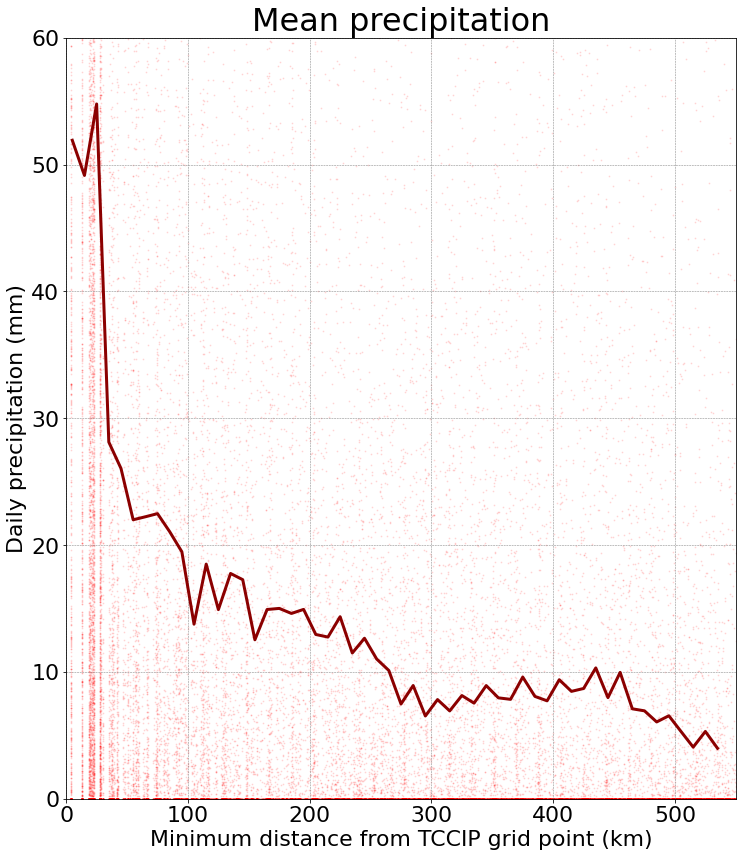

In [26]:
fig=plt.figure(figsize=(12,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs daily rainfall
ax.scatter(distance_list,obs_list,s=1,c='r',alpha=0.1)#,label='IBTrACS TCs')
ax.plot([x+5 for x in bins[:-1]],mean_list,color='darkred',linewidth=3.0)#,label='IBTrACS TCs')
ax.tick_params(labelsize=22)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from TCCIP grid point (km)',fontsize=22)
ax.set_ylabel('Daily precipitation (mm)',fontsize=22)
ax.set_xlim(0,550)
ax.set_ylim(0,60)
ax.set_title('Mean precipitation',fontsize=32)
plt.show()

In [27]:
fig.savefig(dir+'taiwan_ar_proximity_test_1.png')

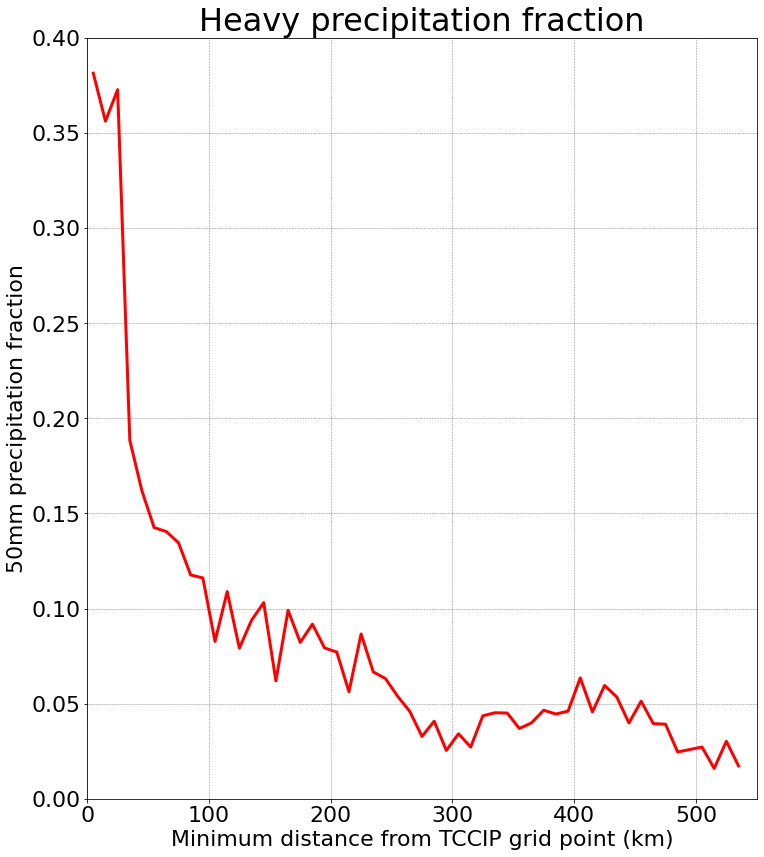

In [33]:
fig=plt.figure(figsize=(12,14))
ax=plt.subplot(1,1,1)
#plot of min distance (from station) vs probability of >=50 mm/day precipitation
ax.plot([x+5 for x in bins[:-1]],prob_50_list,color='r',linewidth=3.0)#,label='IBTrACS TCs')
ax.tick_params(labelsize=22)
ax.grid(True,linestyle='--',linewidth=0.5,color='grey')
ax.set_xlabel('Minimum distance from TCCIP grid point (km)',fontsize=22)
ax.set_ylabel('50mm precipitation fraction',fontsize=22)
ax.set_xlim(0,550)
ax.set_ylim(0,0.4)
ax.set_title('Heavy precipitation fraction',fontsize=32)
plt.show()

In [34]:
fig.savefig(dir+'taiwan_ar_proximity_test_2.png')